In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ml_task_data.csv")
df["margin_percentage"] = df["margin"] / df["sell_price"] 
df["absolute_margin"] = df["margin"] * df["sales"] 
df["revenue"] = df["sell_price"] * df["sales"] 
df =df.sort_values("date")
one_hot = pd.get_dummies(df["product_id"])
one_hot =one_hot.rename(lambda x : x[:5], axis='columns')
df = df.join(one_hot)
df["sales_sma"] = df["sales"].rolling(window=3).mean() # I didnt have luck with this sma after all
df = df.fillna(df.mean())
df

,product_id,date,sell_price,margin,sales,margin_percentage,absolute_margin,revenue,42586,56154,58fba,82b9c,b2141,sales_sma
458,58fba35ac3591d27507b733ea4a6dc1c8b1c2cf04ddbbd...,2019-01-01,82.39,24.72,19,0.300036,469.68,1565.41,0,0,1,0,0,81.617573
224,82b9ca49aa8b92fd1cf0963b52fb1734eda3232303c669...,2019-01-01,65.89,19.77,8,0.300046,158.16,527.12,0,0,0,1,0,81.617573
1912,b2141f3341478ce4ee74781f7da95dcbc3ee6d9a530965...,2019-01-01,36.19,10.86,6,0.300083,65.16,217.14,0,0,0,0,1,11.000000
1676,42586e958c1c38c359654b9f2e9384a3c76377619fed4d...,2019-01-01,43.89,13.17,1,0.300068,13.17,43.89,1,0,0,0,0,5.000000
778,82b9ca49aa8b92fd1cf0963b52fb1734eda3232303c669...,2019-01-02,65.89,19.77,26,0.300046,514.02,1713.14,0,0,0,1,0,11.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,82b9ca49aa8b92fd1cf0963b52fb1734eda3232303c669...,2021-01-27,71.39,21.42,81,0.300042,1735.02,5782.59,0,0,0,1,0,54.000000
1865,42586e958c1c38c359654b9f2e9384a3c76377619fed4d...,2021-01-27,49.39,14.82,19,0.300061,281.58,938.41,1,0,0,0,0,59.000000
233,58fba35ac3591d27507b733ea4a6dc1c8b1c2cf04ddbbd...,2021-01-27,98.89,29.67,53,0.300030,1572.51,5241.17,0,0,1,0,0,51.000000
1266,b2141f3341478ce4ee74781f7da95dcbc3ee6d9a530965...,2021-01-27,38.39,11.52,70,0.300078,806.40,2687.30,0,0,0,0,1,47.333333


In [3]:
# seems like price/sales relationship may be skewed by date - sales may be affected by seasonality
# but after further digging into the problem, I decided to ignore it for my submission - 
# It would consume disproprotional amount of time (disproportional to the fact that it is homework - probably it would be worth it to dig into it for production model)


In [4]:
scaler = MinMaxScaler()
ONE_HOT_COLUMN_NAMES = ["42586", "56154", "58fba", "82b9c", "b2141"]
X = df[["sales"] + ONE_HOT_COLUMN_NAMES]
X = scaler.fit_transform(X)
X

array([[0.0138585 , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.00583516, 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.00437637, 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       ...,
       [0.03865791, 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.05105762, 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.2027717 , 0.        , 1.        , 0.        , 0.        ,
        0.        ]])

In [5]:
Y = df[["sell_price"]]
Y

,sell_price
458,82.39
224,65.89
1912,36.19
1676,43.89
778,65.89
...,...
3481,71.39
1865,49.39
233,98.89
1266,38.39


In [6]:
# my goal is to create model, that will predict price from sales - later I will use this model
# for finding optimal price by trying to predict from randomly choosed sales and checking if
# that randomly choosed sale is maintaining the absolute margin and is also of higher value that the previous,
# for making this work - I want my model to behave as continuous function - and Support Vector Regression is behaving
# like continuous function
svr = SVR(kernel='rbf', C=100, gamma=.1, epsilon=.1)
model = svr.fit(X, Y.values.ravel())
res = model.predict(X)
res

array([ 98.07376375,  72.11329252,  37.2760559 , ...,  95.48137833,
        35.43529358, 219.22593838])

In [7]:
# after trying different kernels - rbf seems like the right choice - It can predict even outliers reasonably well - and I dont risk overfitting here as with eg. polyonimal kernel

# next I will visualize how model preditcs price based on sales


In [8]:
def print_model_prediction_for_product(product_vector, min_sales=0, max_sales=500):
    xaxis = np.linspace(min_sales, max_sales, num=50)
    x_features = [[x]+product_vector for x in xaxis]
    x_features = scaler.transform(x_features)
    y = model.predict(x_features)
    plt.xlabel("sales")
    plt.ylabel("price")
    plt.plot(xaxis, y) 


def get_min_and_max_sales(product_index):
    assert product_index in [0,1,2,3,4]
    min_sales = df[df[ONE_HOT_COLUMN_NAMES[product_index]]==1]["sales"].min()
    max_sales = df[df[ONE_HOT_COLUMN_NAMES[product_index]]==1]["sales"].max()
    return min_sales, max_sales

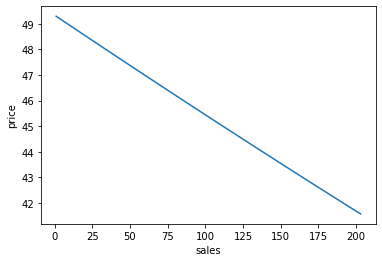

In [9]:
# product 42586
min_sales, max_sales = get_min_and_max_sales(0)
print_model_prediction_for_product([1,0,0,0,0], min_sales, max_sales)

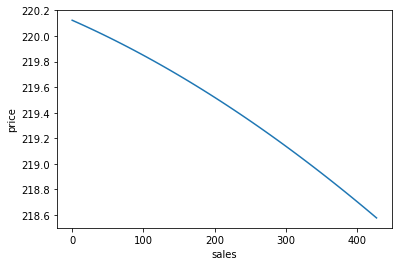

In [10]:
# product 56154

min_sales, max_sales = get_min_and_max_sales(1)
print_model_prediction_for_product([0,1,0,0,0], min_sales, max_sales)

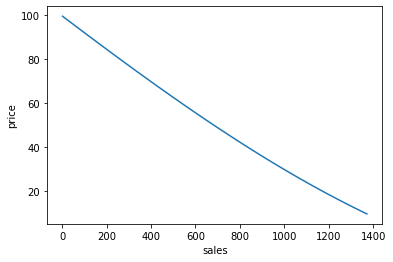

In [11]:
# product 58fba
min_sales, max_sales = get_min_and_max_sales(2)
print_model_prediction_for_product([0,0,1,0,0], min_sales, max_sales)

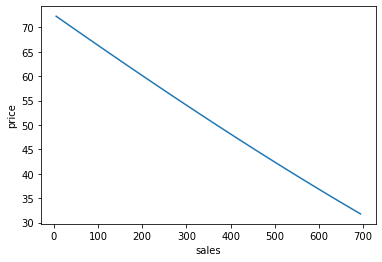

In [12]:
# product 82b9c
min_sales, max_sales = get_min_and_max_sales(3)
print_model_prediction_for_product([0,0,0,1,0], min_sales, max_sales)

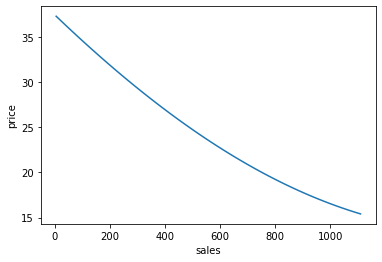

In [13]:
# product b2141
min_sales, max_sales = get_min_and_max_sales(4)
print_model_prediction_for_product([0,0,0,0,1], min_sales, max_sales)

In [14]:
# after visualization I and some double checking I can confirm that this SVR model is usable for my price estimation

# I will now solve the price graphicaly, but for that, I will need
# to figure out the value of absolute margin - which I need to maintain - and also the buy price for each product

In [15]:
def print_revenue_and_margin_outline(product_vector, min_sales=0, max_sales=500, buy_price=None, absolute_margin_to_maintain=None):
    xaxis = np.linspace(min_sales, max_sales, num=50)
    x_features = [[x]+product_vector for x in xaxis]
    x_features_scaled = scaler.transform(x_features)
    y = model.predict(x_features_scaled)
    revenue = y*[_x[0] for _x in x_features]
    plt.xlabel("price")
    plt.ylabel("price * sales")
    plt.plot(y, revenue) 
    margin = y - buy_price
    absolute_margin = margin*[_x[0] for _x in x_features]
    plt.plot(y, absolute_margin)
    
    plt.plot(y, [absolute_margin_to_maintain for _ in y])
    plt.legend(["revenue", "margin", "minimal margin to maintain"], loc ="upper right")
    
    

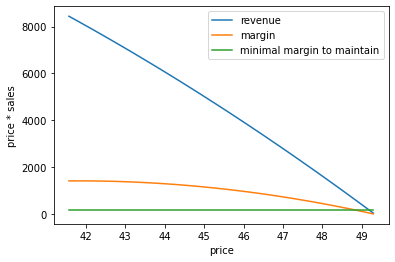

In [16]:
# product 42586
d = df[df["42586"]==1]
absolute_margin_mean = d["absolute_margin"].mean()
buy_price = d.iloc[-1]["sell_price"] - d.iloc[-1]["margin"]
min_sales, max_sales = get_min_and_max_sales(0)
print_revenue_and_margin_outline([1,0,0,0,0], min_sales, max_sales, buy_price, absolute_margin_mean)

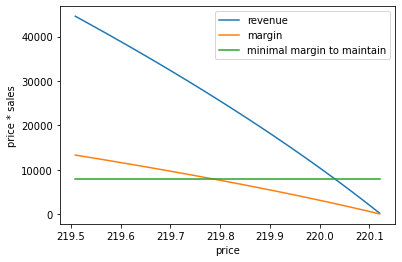

In [17]:
# product 56154
d = df[df["56154"]==1]
absolute_margin_mean = d["absolute_margin"].mean()
buy_price = d.iloc[-1]["sell_price"] - d.iloc[-1]["margin"]
min_sales, max_sales = get_min_and_max_sales(0)
print_revenue_and_margin_outline([0,1,0,0,0], min_sales, max_sales, buy_price, absolute_margin_mean)

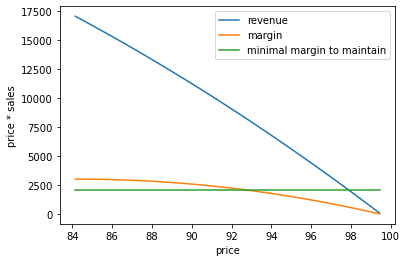

In [18]:
# product 58fba
d = df[df["58fba"]==1]
absolute_margin_mean = d["absolute_margin"].mean()
buy_price = d.iloc[-1]["sell_price"] - d.iloc[-1]["margin"]
min_sales, max_sales = get_min_and_max_sales(0)
print_revenue_and_margin_outline([0,0,1,0,0], min_sales, max_sales, buy_price, absolute_margin_mean)

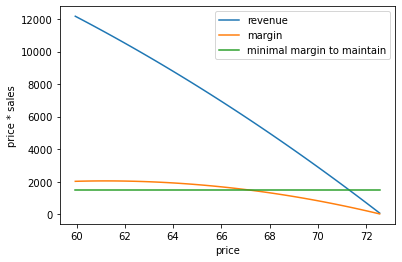

In [19]:
# product 82b9c
d = df[df["82b9c"]==1]
absolute_margin_mean = d["absolute_margin"].mean()
buy_price = d.iloc[-1]["sell_price"] - d.iloc[-1]["margin"]
min_sales, max_sales = get_min_and_max_sales(0)
print_revenue_and_margin_outline([0,0,0,1,0], min_sales, max_sales, buy_price, absolute_margin_mean)

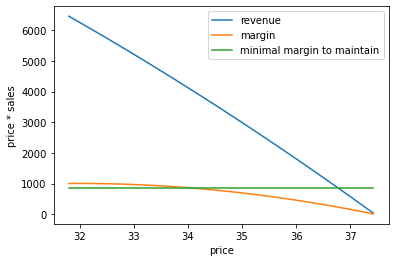

In [20]:
# product b2141
d = df[df["b2141"]==1]
absolute_margin_mean = d["absolute_margin"].mean()
buy_price = d.iloc[-1]["sell_price"] - d.iloc[-1]["margin"]
min_sales, max_sales = get_min_and_max_sales(0)
print_revenue_and_margin_outline([0,0,0,0,1], min_sales, max_sales, buy_price, absolute_margin_mean)

In [21]:
# final prices
price42586 = 42
price56154 = 219.5
price58fba = 84
price82b9c = 60
priceb2141 = 32



In [22]:
# I will solve prices graphically based on 5 graphs above - valid price has to meet few conditions
# based on "Goal is to maximize revenue (sales * sell_price)while maintaining absolute margin - (sell_price - buy_price) * sales" statement
# 1) to maintain absolute margin - we can take into account only prices where yellow line is above green line
# 2) and from range after 1) - we want blue line to by as high as possible

# this actually creates one desision to make - because we clearly dont have data to know for sure, how
# will sales react If we put price outside of the known range we have two options
# 1) stay in range for which we alreade have enough data
# 2) experimentaly go even further away in the direction we believe is the right one - and hope that we wont lose
#    much money in the process of gathering new real data

# here I will evaluate prices for option 1)
# based on the graphs above it seems that that minimizing price is right strategy for all products, so I will 
# write down estimates of suggested price and corresponding margin and revenue for each product

In [23]:
# product 42586
PRICE = 42
MARGIN = 1600
REVENUE = 8400


In [24]:
# product 56154
PRICE = 219.5
MARGIN = 13500
REVENUE = 43000

In [25]:
# product 58fba
PRICE = 84
MARGIN = 3000
REVENUE = 17500

In [26]:
# product 82b9c
PRICE = 60
MARGIN = 2000
REVENUE = 12000

In [27]:
# product b2141
PRICE = 32
MARGIN = 1000
REVENUE = 6000